## DSCI 100 Group Project

In [2]:
library(tidyverse)

players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players_data <- read_csv(players_url)
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
sessions_data <- read_csv(sessions_url)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ─────────────────────────────────

The columns of `players.csv`  and `sessions.csv`, which contain information about players in PLAIcraft pertain to the following definitions:
- `experience` (character);  amount of experience a player has in Minecraft
- `subscribe` (logical); whether the player is subscribed to emails
- `hashedEmail` (character); players email in hashed (coded) form, unique identifier
- `played_hours` (double); number of hours played on the server
- `name` (character); player's pseudonym on PLAIcraft
- `gender` (character); player's gender
- `age` (double); player's age in years
- `individualId` (logical); not accessible: if individual has an id
- `organizationName` (logical); not accessible: if signup is from an organization
- `start_time` and `end_time` (character); date in dd/mm/yyyy format and time in 24-hour format when the player logged onto/off the server
- `original_start_time` and `original_end_time` (double); a time in UNIX timestamp format, logging the scheduled start/end time as number of seconds since January 1 1970 at UTC

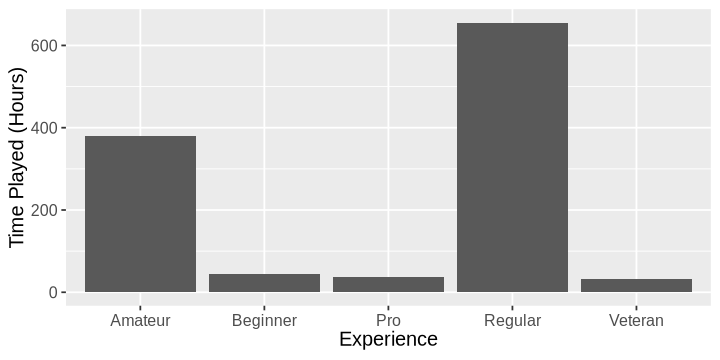

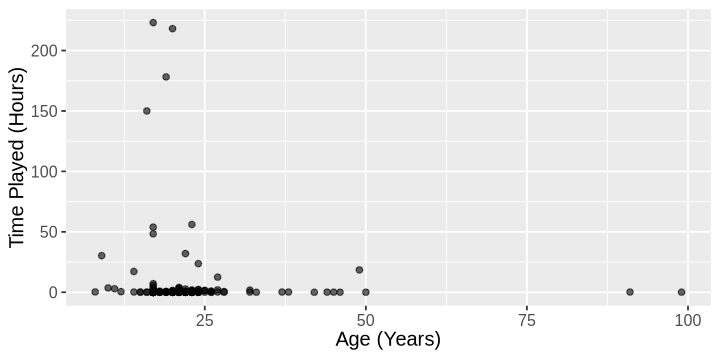

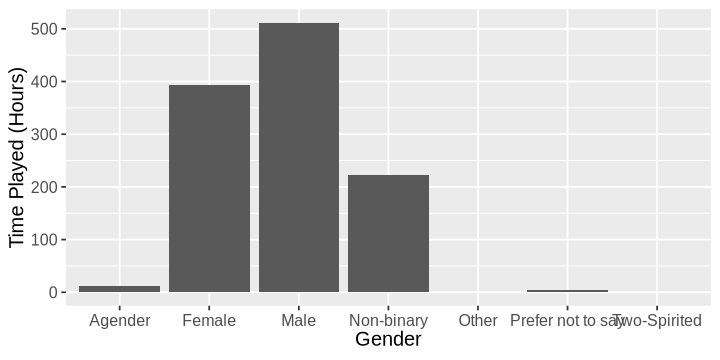

In [3]:
players_ex <- players_data |>
  ggplot(aes(x = experience, y = played_hours)) +
      geom_bar(stat = "identity") +
      labs(x = "Experience",
           y = "Time Played (Hours)") +
      theme(text = element_text(size = 12))

players_age <- players_data |>
  ggplot(aes(x = age, y = played_hours)) +
      geom_point(alpha = 0.6) +
      labs(x = "Age (Years)",
           y = "Time Played (Hours)") +
      theme(text = element_text(size = 12))

players_gend <- players_data |>
  ggplot(aes(x = gender, y = played_hours)) +
      geom_bar(stat = "identity") +
      labs(x = "Gender",
           y = "Time Played (Hours)") +
      theme(text = element_text(size = 12))

options(repr.plot.width = 6, repr.plot.height = 3)
players_ex
players_age
players_gend